# Infer EC50 values for the `171207_Eva2` chip

## Import `Python` modules

In [1]:
import os
import sys
import re
import glob

import xml.etree.ElementTree as ET
sys.path.append("/home/jupyter/tacc-work/jupyter_packages/lib/python2.7/site-packages")
from FlowCytometryTools import *

import numpy as np
import pandas
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)

# Initialize directories
resultsdir = "results/171207_Eva2"
resultsdir_parse_metadata = os.path.join(resultsdir, 'parse_metadata')
dirs = [resultsdir, resultsdir_parse_metadata]
for dir_i in dirs:
    if not os.path.isdir(dir_i):
        os.makedirs(dir_i)

## Make the input experimental-summary file

### Specify all inputs

In [2]:
# Specify the location of FASTQ files
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_5/EVAChip2/'
fastq_summary_file = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_5/manifest.csv'

# Specify the locations of directories with FCS files with part of the FACS data
facs_dir = "/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/facs_data/production_data/"
job_ids = ['Job_58431', 'Job_58213', 'Job_58037']
facs_dirs = ','.join([os.path.join(facs_dir, job_id) for job_id in job_ids])
job_ids = ','.join(job_ids)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Make a list of input XML files with the other part of the FACS data
xml_files = ','.join(glob.glob(
    os.path.join(facs_dir, 'sort_reports', '*/*.xml')
))

# Specify column-specific values to analyze in the metadata files.
library_name = "EVA_Chip2_Jan_2018"
ignore_aq_item_ids = '123585' # ignore the sequencing data for the (trypsin, 0) file

# Specify the output metadata CSV file
experimental_metadata_output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Read in input arguments, as if it were a new script
job_ids = job_ids.split(',')
facs_dirs = facs_dirs.split(',')
xml_files = xml_files.split(',')
ignore_aq_item_ids = ignore_aq_item_ids.split(',')

# Read in data on location of deep-sequencing data
fastq_df = pandas.read_csv(fastq_summary_file)

# Remove entires to ignore, as specified above
indices_to_drop = [i for (i, row) in fastq_df.iterrows() if str(row['aq_item_id']) in ignore_aq_item_ids]
fastq_df.drop(indices_to_drop, inplace=True)

# Piece together paths to FASTQ files and tweak some of entries to match
# expected patterns/cases
fastq_df['filename_prefix'] = fastq_df['filename_prefix'].apply(lambda x: x.replace('_', '-'))
fastq_df['fastq_id'] = fastq_df.apply(lambda row: os.path.join(
    str(row['aq_item_id']), 'Files', row['filename_prefix']
), axis=1)
fastq_df['protease'] = fastq_df['protease'].apply(lambda x: x.lower())
fastq_df['strain'] = fastq_df['strain'].apply(lambda x: x.replace(' ', '_'))

# To conform with previous naming schemes, I will relabel the
# naive sample (naive, 0) to be the naive trypsin sample (trypsin, 0)
fastq_df['protease'] = fastq_df['protease'].apply(lambda x: x.replace('naive', 'trypsin'))

# Index by protease name and concentration
fastq_df.set_index(['protease', 'concentration'], inplace=True)

# Downsample to include only samples within library of interest
fastq_df = fastq_df[fastq_df['strain']==library_name]
fastq_df.sort_index()

aq_item_id                    filename_prefix  \
protease     concentration                                                  
chymotrypsin 9.5                123584     123584-EVAChip2-Chymotrypsin-9   
             28.0               123582    123582-EVAChip2-Chymotrypsin-28   
             83.0               123583    123583-EVAChip2-Chymotrypsin-83   
             250.0              123588   123588-EVAChip2-Chymotrypsin-250   
             750.0              123591   123591-EVAChip2-Chymotrypsin-750   
             2250.0             123592  123592-EVAChip2-Chymotrypsin-2250   
trypsin      0.0                123579              123579-EVAChip2-naive   
             9.5                123580          123580-EVAChip2-Trypsin-9   
             28.0               123581         123581-EVAChip2-Trypsin-28   
             83.0               123586         123586-EVAChip2-Trypsin-83   
             250.0              123587        123587-EVAChip2-Trypsin-250   
             750.0              123589        123589-EVAChip2-Trypsin-750   
             2250.0             123590       123590-EVAChip2-Trypsin-2250   

                                        strain  \
protease     concentration                       
chymotrypsin 9.5            EVA_Chip2_Jan_2018   
             28.0           EVA_Chip2_Jan_2018   
             83.0           EVA_Chip2_Jan_2018   
             250.0          EVA_Chip2_Jan_2018   
             750.0          EVA_Chip2_Jan_2018   
             2250.0         EVA_Chip2_Jan_2018   
trypsin      0.0            EVA_Chip2_Jan_2018   
             9.5            EVA_Chip2_Jan_2018   
             28.0           EVA_Chip2_Jan_2018   
             83.0           EVA_Chip2_Jan_2018   
             250.0          EVA_Chip2_Jan_2018   
             750.0          EVA_Chip2_Jan_2018   
             2250.0         EVA_Chip2_Jan_2018   

                                                                  fastq_id  
protease     concentration                                                  
chymotrypsin 9.5               123584/Files/123584-EVAChip2-Chymotrypsin-9  
             28.0             123582/Files/123582-EVAChip2-Chymotrypsin-28  
             83.0             123583/Files/123583-EVAChip2-Chymotrypsin-83  
             250.0           123588/Files/123588-EVAChip2-Chymotrypsin-250  
             750.0           123591/Files/123591-EVAChip2-Chymotrypsin-750  
             2250.0         123592/Files/123592-EVAChip2-Chymotrypsin-2250  
trypsin      0.0                        123579/Files/123579-EVAChip2-naive  
             9.5                    123580/Files/123580-EVAChip2-Trypsin-9  
             28.0                  123581/Files/123581-EVAChip2-Trypsin-28  
             83.0                  123586/Files/123586-EVAChip2-Trypsin-83  
             250.0                123587/Files/123587-EVAChip2-Trypsin-250  
             750.0                123589/Files/123589-EVAChip2-Trypsin-750  
             2250.0              123590/Files/123590-EVAChip2-Trypsin-2250

### For each sample in the experiment, quantify the total number of events and the number of events that passed the sorting threshold

In [3]:
def s_log(sample, channel_names):
    new_sample = sample.copy()
    new_data = new_sample.data

    for channel_name in channel_names:
        new_data[channel_name] = np.log10(new_data[channel_name])
        
    new_data.replace(to_replace = -np.inf, value = -1, inplace = True)
    new_data = new_data.dropna()
    new_sample.data = new_data
    
    return new_sample

In [4]:
# Read in data from the `manifest.txt` files
manifest_df = pandas.DataFrame()
for (job_id, facs_dir) in zip(job_ids, facs_dirs):
    df = pandas.read_csv(os.path.join(facs_dir, 'manifest.txt'))
    df['job_id'] = job_id
    df['directory'] = facs_dir
    df['specimen'] = df['filename'].apply(lambda x : x[:12])
    df['tube'] = df['filename'].apply(lambda x : x[13:21])
    df['strain'] = df['strain'].apply(lambda x: x.replace(' ', '_'))
    manifest_df = pandas.concat([manifest_df, df])
manifest_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)

In [5]:
# Quantify the total number of events and events passing the gate
fitc_data_dict = {}
total_number_of_recorded_events = []
number_of_events_passing_fitc_gate = []
for (i, row) in manifest_df.iterrows():
    
    # Read in the data for the appropriate channel and transform it to a log10 scale
    fcs_file = os.path.join(row['directory'], row['filename'])
    sample = FCMeasurement(ID='Test Sample', datafile=fcs_file)
    #print("Analyzing the channel: {0}".format(channel_name))
    sample = s_log(sample, [facs_channel_name])
    df = sample.data
    
    # Count the number of total events and events passing the gate
    total_number_of_recorded_events.append(len(df.index.values))
    number_of_events_passing_fitc_gate.append(
        sum(df[facs_channel_name] > 3.0)
    )

# Append the FACS data to the manifest dataframe
manifest_df['total_number_of_recorded_events'] = total_number_of_recorded_events
manifest_df['number_of_events_passing_fitc_gate'] = number_of_events_passing_fitc_gate
manifest_df['fraction_collected'] = \
    manifest_df['number_of_events_passing_fitc_gate'] / manifest_df['total_number_of_recorded_events']
columns_to_show = [
    'strain', 'protease', 'concentration', 'total_number_of_recorded_events',
    'number_of_events_passing_fitc_gate', 'fraction_collected'
]
manifest_df = manifest_df[
    manifest_df['strain'] == library_name
]
manifest_df[columns_to_show]

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


strain      protease  \
job_id    specimen     tube                                         
Job_58431 Specimen_001 Tube_006  EVA_Chip2_Jan_2018       trypsin   
                       Tube_007  EVA_Chip2_Jan_2018       trypsin   
                       Tube_008  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_010  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_011  EVA_Chip2_Jan_2018       trypsin   
Job_58213 Specimen_001 Tube_006  EVA_Chip2_Jan_2018       trypsin   
                       Tube_007  EVA_Chip2_Jan_2018       trypsin   
                       Tube_008  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_010  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_011  EVA_Chip2_Jan_2018       trypsin   
Job_58037 Specimen_001 Tube_006  EVA_Chip2_Jan_2018       trypsin   
                       Tube_007  EVA_Chip2_Jan_2018       trypsin   
                       Tube_008  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_010  EVA_Chip2_Jan_2018       trypsin   

                                 concentration  \
job_id    specimen     tube                      
Job_58431 Specimen_001 Tube_006          750.0   
                       Tube_007         2250.0   
                       Tube_008          750.0   
                       Tube_009         2250.0   
                       Tube_010            0.0   
                       Tube_011            0.0   
Job_58213 Specimen_001 Tube_006           83.0   
                       Tube_007          250.0   
                       Tube_008           83.0   
                       Tube_009          250.0   
                       Tube_010            0.0   
                       Tube_011            0.0   
Job_58037 Specimen_001 Tube_006            9.5   
                       Tube_007           28.0   
                       Tube_008            9.5   
                       Tube_009           28.0   
                       Tube_010            0.0   

                                 total_number_of_recorded_events  \
job_id    specimen     tube                                        
Job_58431 Specimen_001 Tube_006                            99996   
                       Tube_007                            99990   
                       Tube_008                            99995   
                       Tube_009                            99999   
                       Tube_010                            99995   
                       Tube_011                            99997   
Job_58213 Specimen_001 Tube_006                            99997   
                       Tube_007                            99998   
                       Tube_008                            99998   
                       Tube_009                           100000   
                       Tube_010                           100000   
                       Tube_011                            99998   
Job_58037 Specimen_001 Tube_006                            99999   
                       Tube_007                            99997   
                       Tube_008                            99998   
                       Tube_009                            99995   
                       Tube_010                            99996   

                                 number_of_events_passing_fitc_gate  \
job_id    specimen     tube                                           
Job_58431 Specimen_001 Tube_006                               17283   
                       Tube_007                                5310   
                       Tube_008                               13517   
                       Tube_009                                4356   
                       Tube_010                               6

Go through the dataframe, making a list of samples to drop. Specifically, I will drop naive samples that are not from the first day of sorting. But, before doing so, I will record data from them to include in the `parent_expression` column of the output file.

In [6]:
map_job_id_to_sort_round = {
    'Job_58037' : 1, 'Job_58213' : 2, 'Job_58431' : 3
}
naive_sample_expression = {'trypsin':{}, 'chymotrypsin':{}}
list_of_indices_to_drop = []

for (i, row) in manifest_df.iterrows():
    (job_id, specimen, tube) = i
    sort_round = map_job_id_to_sort_round[job_id]
    if row['concentration'] == 0.0:
        naive_sample_expression[row['protease']][sort_round] = row['fraction_collected']
        if sort_round != 1:
            list_of_indices_to_drop.append(i)
            
manifest_df.drop(list_of_indices_to_drop, axis='index', inplace=True)
manifest_df[columns_to_show]

strain      protease  \
job_id    specimen     tube                                         
Job_58431 Specimen_001 Tube_006  EVA_Chip2_Jan_2018       trypsin   
                       Tube_007  EVA_Chip2_Jan_2018       trypsin   
                       Tube_008  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip2_Jan_2018  chymotrypsin   
Job_58213 Specimen_001 Tube_006  EVA_Chip2_Jan_2018       trypsin   
                       Tube_007  EVA_Chip2_Jan_2018       trypsin   
                       Tube_008  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip2_Jan_2018  chymotrypsin   
Job_58037 Specimen_001 Tube_006  EVA_Chip2_Jan_2018       trypsin   
                       Tube_007  EVA_Chip2_Jan_2018       trypsin   
                       Tube_008  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip2_Jan_2018  chymotrypsin   
                       Tube_010  EVA_Chip2_Jan_2018       trypsin   

                                 concentration  \
job_id    specimen     tube                      
Job_58431 Specimen_001 Tube_006          750.0   
                       Tube_007         2250.0   
                       Tube_008          750.0   
                       Tube_009         2250.0   
Job_58213 Specimen_001 Tube_006           83.0   
                       Tube_007          250.0   
                       Tube_008           83.0   
                       Tube_009          250.0   
Job_58037 Specimen_001 Tube_006            9.5   
                       Tube_007           28.0   
                       Tube_008            9.5   
                       Tube_009           28.0   
                       Tube_010            0.0   

                                 total_number_of_recorded_events  \
job_id    specimen     tube                                        
Job_58431 Specimen_001 Tube_006                            99996   
                       Tube_007                            99990   
                       Tube_008                            99995   
                       Tube_009                            99999   
Job_58213 Specimen_001 Tube_006                            99997   
                       Tube_007                            99998   
                       Tube_008                            99998   
                       Tube_009                           100000   
Job_58037 Specimen_001 Tube_006                            99999   
                       Tube_007                            99997   
                       Tube_008                            99998   
                       Tube_009                            99995   
                       Tube_010                            99996   

                                 number_of_events_passing_fitc_gate  \
job_id    specimen     tube                                           
Job_58431 Specimen_001 Tube_006                               17283   
                       Tube_007                                5310   
                       Tube_008                               13517   
                       Tube_009                                4356   
Job_58213 Specimen_001 Tube_006                               32315   
                       Tube_007                               17765   
                       Tube_008                               35947   
                       Tube_009                               22232   
Job_58037 Specimen_001 Tube_006                               13890   
                       Tube_007                                9902   
                       Tube_008                               18040   
                       Tube_009                               14690   
                       Tube_010                               20470   

                                 fraction_collected  
job_id    specimen     tube                          
Job_58431 Specimen_001 Tube_006            0.172837  
         

Read in data from the XML files on the total number of cells collected. I will do this for all XML files the BIOFAB has uploaded, even ones that aren't relevant to this experiment. Then, I will identify the relevant ones using the `job_id`, `specimen`, and `tube` columns.

In [7]:
# Compile data in each XML file
xml_data_dict = {
    key : []
    for key in ['job_id', 'specimen', 'tube', 'cells_collected', 'intended_number_of_cells_collected'] #
}
cells_collected_pattern = re.compile(r'\w+ : (?P<cells_collected>\d+) / (?P<intended_number_of_cells_collected>\d+)')
for filename in xml_files:
    tree = ET.parse(filename)
    root = tree.getroot()

    # Get experiment metadata
    xml_data_dict['job_id'].append( root.findall(".//*[@name='Experiment']")[0].get('value') )
    xml_data_dict['specimen'].append( root.findall(".//*[@name='Specimen']")[0].get('value') )
    xml_data_dict['tube'].append( root.findall(".//*[@name='Tube']")[0].get('value') )
    xml_data_dict['xmlfile'] = filename
    
    # Get experiment counts
    cells_collected_data = root[4].findall(".//*[@col='1']")[0].text
    match = re.match(cells_collected_pattern, cells_collected_data)
    if match:
        xml_data_dict['cells_collected'].append(
            int(match.group('cells_collected'))
        )
        xml_data_dict['intended_number_of_cells_collected'].append(
            int(match.group('intended_number_of_cells_collected'))
        )
    else:
        xml_data_dict['cells_collected'].append(None)
        xml_data_dict['intended_number_of_cells_collected'].append(None)
          
# Convert data to a dataframe
xml_data_df = pandas.DataFrame.from_dict(xml_data_dict)
xml_data_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)
xml_data_df

cells_collected  \
job_id    specimen     tube                        
Plan_8486 Specimen_001 Tube_002        1200000.0   
                       Tube_003        1200000.0   
                       Tube_004        1200000.0   
                       Tube_002              NaN   
                       Tube_004              NaN   
                       Tube_005         387082.0   
Job_57759 Specimen_001 Tube_009        1058966.0   
                       Tube_008        2150790.0   
                       Tube_007        1739743.0   
                       Tube_006        2402586.0   
Job_59575 Specimen_001 Tube_009         288000.0   
                       Tube_007         648000.0   
                       Tube_006        2496000.0   
                       Tube_008        2160000.0   
Job_60063 Specimen_001 Tube_009        6384000.0   
                       Tube_006        7704000.0   
                       Tube_008        7704000.0   
                       Tube_007        6312000.0   
Job_58037 Specimen_001 Tube_008        2184000.0   
                       Tube_009           7955.0   
                       Tube_007        1200000.0   
                       Tube_010        2472000.0   
                       Tube_009        1776000.0   
                       Tube_006        1680000.0   
Plan_8290 Specimen_001 Tube_007        1200000.0   
                       Tube_008         141510.0   
                       Tube_006        1200000.0   
                       Tube_009         105012.0   
Plan_9312 Round_1      Tube_008        1200000.0   
                       Tube_007        1200000.0   
...                                          ...   
Plan_8714 Round_2      Tube_006        1200000.0   
                       Tube_009        1200000.0   
                       Tube_008        1200000.0   
          Round_3      Tube_006        1200000.0   
          Specimen_001 Tube_010        1200000.0   
          Round_3      Tube_009          77876.0   
          Specimen_001 Tube_007        1200000.0   
          Round_3      Tube_007          61791.0   
Job_59353 Specimen_001 Tube_007          46401.0   
                       Tube_008        5938598.0   
                       Tube_007        5385501.0   
                       Tube_009        4466472.0   
                       Tube_006        6713937.0   
Job_56649 Specimen_001 Tube_006         895311.0   
                       Tube_008        2564592.0   
                       Tube_007         267584.0   
                       Tube_009        1127664.0   
Plan_8239 Specimen_001 Tube_006         235769.0   
                       Tube_005        1200000.0   
                       Tube_004        1200000.0   
                       Tube_003        1200000.0   
Job_60359 Specimen_001 Tube_009         240000.0   
                       Tube_006        2107594.0   
                       Tube_007         648405.0   
                       Tube_008        2137779.0   
                       Tube_006           3954.0   
Job_58213 Specimen_001 Tube_008        4344000.0   
                       Tube_009        2371057.0   
                       Tube_006        3900000.0   
                       Tube_007        1823606.0   

                                 intended_number_of_cells_collected  \
job_id    specimen     tube                                           
Plan_8486 Specimen_001 Tube_002                           1200000.0   
                       Tube_003                           1200000.0   
                       Tube_004                           1200000.0   
                       Tube_002                                 NaN   
                       Tube_004                                 NaN   
                       Tube_005                           1200000.0   
Job_57759 Specimen_001 Tube_009                           2496000.0   
                       Tube_008                           4020000.0   
                       Tube_007               

Merge the FACS data from the two input sources

In [8]:
facs_df = manifest_df.merge(xml_data_df, left_index=True, right_index=True, how='left')
facs_df = facs_df[
    facs_df['strain'] == library_name
]
facs_df.set_index(['protease', 'concentration'], inplace=True, drop=False)
columns_to_show = ['cells_collected', 'fraction_collected']
facs_df[columns_to_show].sort_index()

cells_collected  fraction_collected  \
protease     concentration                                        
chymotrypsin 9.5                  2184000.0            0.180404   
             28.0                    7955.0            0.146907   
             28.0                 1776000.0            0.146907   
             83.0                 4344000.0            0.359477   
             250.0                2371057.0            0.222320   
             750.0                1656000.0            0.135177   
             2250.0                540000.0            0.043560   
trypsin      0.0                  2472000.0            0.204708   
             9.5                  1680000.0            0.138901   
             28.0                 1200000.0            0.099023   
             83.0                 3900000.0            0.323160   
             250.0                1823606.0            0.177654   
             750.0                2112000.0            0.172837   
             2250.0                660000.0            0.053105   

                                                                      xmlfile  
protease     concentration                                                     
chymotrypsin 9.5            /work/05402/haddox/jupyter/sd2e-community/shar...  
             28.0           /work/05402/haddox/jupyter/sd2e-community/shar...  
             28.0           /work/05402/haddox/jupyter/sd2e-community/shar...  
             83.0           /work/05402/haddox/jupyter/sd2e-community/shar...  
             250.0          /work/05402/haddox/jupyter/sd2e-community/shar...  
             750.0          /work/05402/haddox/jupyter/sd2e-community/shar...  
             2250.0         /work/05402/haddox/jupyter/sd2e-community/shar...  
trypsin      0.0            /work/05402/haddox/jupyter/sd2e-community/shar...  
             9.5            /work/05402/haddox/jupyter/sd2e-community/shar...  
             28.0           /work/05402/haddox/jupyter/sd2e-community/shar...  
             83.0           /work/05402/haddox/jupyter/sd2e-community/shar...  
             250.0          /work/05402/haddox/jupyter/sd2e-community/shar...  
             750.0          /work/05402/haddox/jupyter/sd2e-community/shar...  
             2250.0         /work/05402/haddox/jupyter/sd2e-community/shar...

Merge the FACS and deep-sequencing data

In [23]:
df = fastq_df.merge(facs_df, left_index=True, right_index=True, how="outer")
columns_to_write = ['fastq_id', 'cells_collected', 'fraction_collected']
df = df[columns_to_write]
df.reset_index(inplace=True)
df

,protease,concentration,fastq_id,cells_collected,fraction_collected
0,chymotrypsin,9.5,123584/Files/123584-EVAChip2-Chymotrypsin-9,2184000.0,0.180404
1,chymotrypsin,28.0,123582/Files/123582-EVAChip2-Chymotrypsin-28,7955.0,0.146907
2,chymotrypsin,28.0,123582/Files/123582-EVAChip2-Chymotrypsin-28,1776000.0,0.146907
3,chymotrypsin,83.0,123583/Files/123583-EVAChip2-Chymotrypsin-83,4344000.0,0.359477
4,chymotrypsin,250.0,123588/Files/123588-EVAChip2-Chymotrypsin-250,2371057.0,0.222320
5,chymotrypsin,750.0,123591/Files/123591-EVAChip2-Chymotrypsin-750,1656000.0,0.135177
6,chymotrypsin,2250.0,123592/Files/123592-EVAChip2-Chymotrypsin-2250,540000.0,0.043560
7,trypsin,0.0,123579/Files/123579-EVAChip2-naive,2472000.0,0.204708
8,trypsin,9.5,123580/Files/123580-EVAChip2-Trypsin-9,1680000.0,0.138901
9,trypsin,28.0,123581/Files/123581-EVAChip2-Trypsin-28,1200000.0,0.099023


There are two entries for (chymotrypsin, 28) one with a large number of counts, one with a small number. I will remove the row with the smaller number.

In [24]:
df.drop([1], inplace=True)

Add a row for a naive sample for chymotrypsin, using the same deep-sequencing data as for trypsin 

In [25]:
df_with_extra_row = pandas.DataFrame.from_dict(
    {
        'protease' : ['chymotrypsin'],
        'concentration' : [0],
        'fastq_id' : [df.iloc[6]['fastq_id']],
        'cells_collected' : [df.iloc[6]['cells_collected']],
        'fraction_collected' : [df.iloc[6]['fraction_collected']]
    }
)
df_with_extra_row
df = pandas.concat([df, df_with_extra_row])

Show concatenated dataframe, sorted by protease and protease concentration.

In [26]:
df.sort_values(by=['protease', 'concentration'], inplace=True)
df

,cells_collected,concentration,fastq_id,fraction_collected,protease
0,2472000.0,0.0,123579/Files/123579-EVAChip2-naive,0.204708,chymotrypsin
0,2184000.0,9.5,123584/Files/123584-EVAChip2-Chymotrypsin-9,0.180404,chymotrypsin
2,1776000.0,28.0,123582/Files/123582-EVAChip2-Chymotrypsin-28,0.146907,chymotrypsin
3,4344000.0,83.0,123583/Files/123583-EVAChip2-Chymotrypsin-83,0.359477,chymotrypsin
4,2371057.0,250.0,123588/Files/123588-EVAChip2-Chymotrypsin-250,0.222320,chymotrypsin
5,1656000.0,750.0,123591/Files/123591-EVAChip2-Chymotrypsin-750,0.135177,chymotrypsin
6,540000.0,2250.0,123592/Files/123592-EVAChip2-Chymotrypsin-2250,0.043560,chymotrypsin
7,2472000.0,0.0,123579/Files/123579-EVAChip2-naive,0.204708,trypsin
8,1680000.0,9.5,123580/Files/123580-EVAChip2-Trypsin-9,0.138901,trypsin
9,1200000.0,28.0,123581/Files/123581-EVAChip2-Trypsin-28,0.099023,trypsin


Manually add missing columns

In [27]:
# Add columns
df['experiment_id'] = library_name
df['selection_strength'] = 2 * [i for i in range(0,7)]
df['conc_factor'] = 2 * ['', '3', '3', '3', '3', '3', '3']
df['parent'] = 2 * ['', '0', '0', '2', '2', '4', '4']

Add the row called `parent_expression`, which reports the fraction of collected cells (i.e., passed the selection threshold) in a naive sample that was ***not*** treated with protease and which was sorted on the same day as protease-treated samples.

In [31]:
# Make a dictionary to map protease concentration to sort round
map_protease_conc_to_sort_round = {
    0.0 : 1,
    9.5 : 1,
    28.0 : 1,
    83.0 : 2,
    250.0 : 2,
    750.0 : 3,
    2250.0 : 3
}

# Add a `parent_expression` column to the dataframe. Use the same value for
# all protease-treated samples from the first sort round, regardless of protease.
# This value is derived from (trypsin, 0), but is relative to both proteases
# since it is naive sample. Add blank entires for the naive samples from the first
# sort.
parent_expression_list = []
for (i, row) in df.iterrows():
    protease = row['protease']
    concentration = row['concentration']
    sort_round = map_protease_conc_to_sort_round[concentration]
    if concentration == 0.0:
        parent_expression_list.append('')
    elif (protease, sort_round) == ('chymotrypsin', 1):
        parent_expression_list.append(naive_sample_expression['trypsin'][sort_round])
    else:
        parent_expression_list.append(naive_sample_expression[protease][sort_round])
df['parent_expression'] = parent_expression_list
df

,cells_collected,concentration,fastq_id,fraction_collected,protease,experiment_id,selection_strength,conc_factor,parent,parent_expression
0,2472000.0,0.0,123579/Files/123579-EVAChip2-naive,0.204708,chymotrypsin,Inna_April_2016_rep2,0,,,
0,2184000.0,9.5,123584/Files/123584-EVAChip2-Chymotrypsin-9,0.180404,chymotrypsin,Inna_April_2016_rep2,1,3,0,0.204708
2,1776000.0,28.0,123582/Files/123582-EVAChip2-Chymotrypsin-28,0.146907,chymotrypsin,Inna_April_2016_rep2,2,3,0,0.204708
3,4344000.0,83.0,123583/Files/123583-EVAChip2-Chymotrypsin-83,0.359477,chymotrypsin,Inna_April_2016_rep2,3,3,2,0.52549
4,2371057.0,250.0,123588/Files/123588-EVAChip2-Chymotrypsin-250,0.222320,chymotrypsin,Inna_April_2016_rep2,4,3,2,0.52549
5,1656000.0,750.0,123591/Files/123591-EVAChip2-Chymotrypsin-750,0.135177,chymotrypsin,Inna_April_2016_rep2,5,3,4,0.687104
6,540000.0,2250.0,123592/Files/123592-EVAChip2-Chymotrypsin-2250,0.043560,chymotrypsin,Inna_April_2016_rep2,6,3,4,0.687104
7,2472000.0,0.0,123579/Files/123579-EVAChip2-naive,0.204708,trypsin,Inna_April_2016_rep2,0,,,
8,1680000.0,9.5,123580/Files/123580-EVAChip2-Trypsin-9,0.138901,trypsin,Inna_April_2016_rep2,1,3,0,0.204708
9,1200000.0,28.0,123581/Files/123581-EVAChip2-Trypsin-28,0.099023,trypsin,Inna_April_2016_rep2,2,3,0,0.204708


Rename columns and show the final dataframe.

In [33]:
# Rename columns
df.rename(
    {'protease':'protease_type'},
    inplace=True,
    axis='columns'
)
column_order = [
    'experiment_id', 'protease_type', 'concentration', 'selection_strength', 'parent', 'conc_factor', 'fastq_id',
    'parent_expression', 'fraction_collected', 'cells_collected'
]
df[column_order]

,experiment_id,protease_type,concentration,selection_strength,parent,conc_factor,fastq_id,parent_expression,fraction_collected,cells_collected
0,Inna_April_2016_rep2,chymotrypsin,0.0,0,,,123579/Files/123579-EVAChip2-naive,,0.204708,2472000.0
0,Inna_April_2016_rep2,chymotrypsin,9.5,1,0,3,123584/Files/123584-EVAChip2-Chymotrypsin-9,0.204708,0.180404,2184000.0
2,Inna_April_2016_rep2,chymotrypsin,28.0,2,0,3,123582/Files/123582-EVAChip2-Chymotrypsin-28,0.204708,0.146907,1776000.0
3,Inna_April_2016_rep2,chymotrypsin,83.0,3,2,3,123583/Files/123583-EVAChip2-Chymotrypsin-83,0.52549,0.359477,4344000.0
4,Inna_April_2016_rep2,chymotrypsin,250.0,4,2,3,123588/Files/123588-EVAChip2-Chymotrypsin-250,0.52549,0.222320,2371057.0
5,Inna_April_2016_rep2,chymotrypsin,750.0,5,4,3,123591/Files/123591-EVAChip2-Chymotrypsin-750,0.687104,0.135177,1656000.0
6,Inna_April_2016_rep2,chymotrypsin,2250.0,6,4,3,123592/Files/123592-EVAChip2-Chymotrypsin-2250,0.687104,0.043560,540000.0
7,Inna_April_2016_rep2,trypsin,0.0,0,,,123579/Files/123579-EVAChip2-naive,,0.204708,2472000.0
8,Inna_April_2016_rep2,trypsin,9.5,1,0,3,123580/Files/123580-EVAChip2-Trypsin-9,0.204708,0.138901,1680000.0
9,Inna_April_2016_rep2,trypsin,28.0,2,0,3,123581/Files/123581-EVAChip2-Trypsin-28,0.204708,0.099023,1200000.0


Write the above dataframe to an output file

In [34]:
print("Writing metadata to the experimental summary file: {0}".format(experimental_metadata_output_file))
df[column_order].to_csv(experimental_metadata_output_file, index=False)

Writing metadata to the experimental summary file: results/171207_Eva2/parse_metadata/experimental_metadata_from_script.csv


## Compute EC50 values from the input deep-sequencing and FACS data

In [35]:
# Define input variables
data_dir = 'data/171207_Eva2/'
designed_sequences_file = os.path.join(data_dir, 'designed_sequences_eva2.csv')
experimental_summary_file = os.path.join(experimental_metadata_output_file)
fastq_dir = fastq_dir
pear_path = '/home/05402/haddox/software/pear/bin/pear'
output_dir = resultsdir

In [36]:
# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/compute_ec50_values_from_deep_sequencing_data.py',
    '--designed_sequences_file {0}'.format(designed_sequences_file),
    '--experimental_summary_file {0}'.format(experimental_summary_file),
    '--fastq_dir {0}'.format(fastq_dir),
    '--pear_path {0}'.format(pear_path),
    '--output_dir {0}'.format(output_dir)
])

#! {cmd}
print(cmd)

python scripts/compute_ec50_values_from_deep_sequencing_data.py --designed_sequences_file data/171207_Eva2/designed_sequences_eva2.csv --experimental_summary_file results/171207_Eva2/parse_metadata/experimental_metadata_from_script.csv --fastq_dir /work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_5/EVAChip2/ --pear_path /home/05402/haddox/software/pear/bin/pear --output_dir results/171207_Eva2


Read in the stability scores for each protease and make a single dataframe with data from each, with suffixes of `_t` or `_c` indicating that the data is derived from trypsin or chymotrypsin, respectively.

In [2]:
# Read in data for each protease, making the `name` column the index
# in each case
trypsin_df = pandas.read_csv(
    os.path.join(resultsdir, 'stability_scores/trypsin_stability_scores.txt'), sep='\t'
)
chymotrypsin_df = pandas.read_csv(
    os.path.join(resultsdir, 'stability_scores/chymotrypsin_stability_scores.txt'), sep='\t'
)
trypsin_df.set_index('name', inplace=True)
chymotrypsin_df.set_index('name', inplace=True)

# Merge the dataframes, using `_t` and `_c` as suffixes to indicate
# which data is from trypsin and chymotrypsin, respectively
stability_scores_df = trypsin_df.merge(
    chymotrypsin_df,
    left_index=True,
    right_index=True,
    how='outer',
    suffixes=['_t', '_c']
)
stability_scores_df['stabilityscore'] = stability_scores_df.apply(
    lambda row: min(row['stabilityscore_t'], row['stabilityscore_c']), axis=1
)
stability_scores_outfile = os.path.join(resultsdir, 'stability_scores/stability_scores.txt')
print("Writing merged stability scores to the file: {0}".format(stability_scores_outfile))
stability_scores_df.to_csv(stability_scores_outfile, sep='\t')

Writing merged stability scores to the file: results/171207_Eva2/stability_scores/stability_scores.txt


Look at the correlation between the stability scores for trypsin and chymotrypsin.

0.711386722206


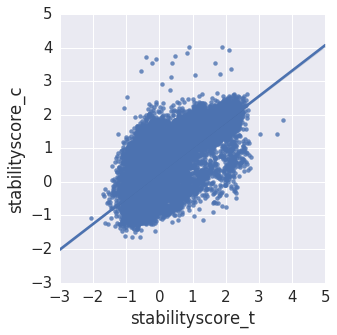

In [3]:
print(stability_scores_df['stabilityscore_t'].corr(stability_scores_df['stabilityscore_c']))
sns.lmplot(x='stabilityscore_t', y='stabilityscore_c', data=stability_scores_df)

Look at the distribution of stability scores for trypsin and chymotrypsin.

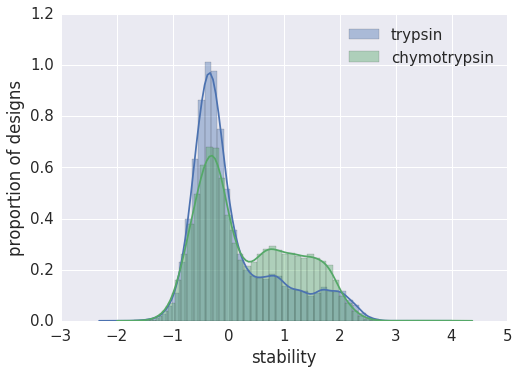

In [4]:
sns.distplot(stability_scores_df['stabilityscore_t'], label='trypsin')
sns.distplot(stability_scores_df['stabilityscore_c'], label='chymotrypsin')
plt.ylabel('proportion of designs')
plt.xlabel('stability')
plt.legend()
plt.show()

## To do:

* Quantify sequencing depth
* Look at the distribution of counts over time

Quantify the number of assembled reads per sample

In [ ]:
def ParsePAREOutfile(outfile):
    """
    This function parses the output data generated by PARE when assemblying paired-end reads
    
    Args:
        `outfile`: the path to a file with the output data generated by PARE
        
    Returns:
        A tupple with the following three variables in the order they appear in the below list:
            `n_assembled_reads` : the total number of assembled reads
            `n_discarded_reads` : the total number of discarded reads
            `n_non_assembled_reads` : the total number of non_assembled_reads
    """
    
    # Pattern used to extract data
    n_reads_pattern = re.compile(r'\: (?P<n_reads>[\d,]+) /')
    
    # Use regular expressions to extract the relevant info from the file
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = n_total_reads = None
    with open(outfile) as f:
        #print(f.readlines())
        for line in f:
            if 'Assembled reads .' in line:
                if n_assembled_reads:
                    raise ValueError("Already found data for `n_assembled_reads`")
                n_assembled_match = re.search(n_reads_pattern, line)
                n_assembled_reads = int(n_assembled_match.group('n_reads').replace(',', ''))
                
            elif 'Discarded reads .' in line:
                if n_discarded_reads:
                    raise ValueError("Already found data for `n_discarded_reads`")
                n_discarded_match = re.search(n_reads_pattern, line)
                n_discarded_reads = int(n_discarded_match.group('n_reads').replace(',', ''))
                
            elif 'Not assembled reads .' in line:
                if n_non_assembled_reads:
                    raise ValueError("Already found data for `n_non_assembled_reads`")
                n_non_assembled_match = re.search(n_reads_pattern, line)
                n_non_assembled_reads = int(n_non_assembled_match.group('n_reads').replace(',', ''))
    
    return (n_assembled_reads, n_discarded_reads, n_non_assembled_reads)


In [ ]:
# Find log files from PARE
pare_log_dir = os.path.join(resultsdir, 'paired_FASTQ_files')

selection_indices = list(range(0,7))
experiment_names = ['trypsin_{0}'.format(i) for i in selection_indices] + \
    ['chymotrypsin_{0}'.format(i) for i in selection_indices]
log_files = glob.glob(os.path.join(pare_log_dir, '*.log'))
log_files_dict = {
    experiment_name : []
    for experiment_name in experiment_names
}
# For each log file, look for an experimental name that matches the beginning
# of the base name of the log file
for log_file_name in log_files:
    matching_experiments = []
    for experiment_name in log_files_dict:
        log_file_basename = os.path.basename(log_file_name)
        if log_file_basename.find('{0}-'.format(experiment_name)) == 0:
            log_files_dict[experiment_name].append(log_file_name)
            matching_experiments.append(experiment_name)
    if len(matching_experiments) == 0:
        raise ValueError("Could not find a matching experiment for the log file: {0}".format(log_file_name))
    if len(matching_experiments) > 1:
        print(matching_experiments)
        raise ValueError("Found multiple matching experiments for the log file: {0}".format(log_file_name))
    assert len(matching_experiments) == 1

In [ ]:
# Read in depth and quality scores from the output of the `PEAR` program and store in a pandas dataframe
assembly_d = {
    key : []
    for key in ['experiment_name', 'n_assembled_reads', 'n_discarded_reads', 'n_non_assembled_reads']
}
for experiment_name in log_files_dict:
    assembly_d['experiment_name'].append(experiment_name)
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = 0
    for log_file_name in log_files_dict[experiment_name]:
        (n_assembled_reads_i, n_discarded_reads_i, n_non_assembled_reads_i) = \
            ParsePAREOutfile(log_file_name)
        n_assembled_reads += n_assembled_reads_i
        n_discarded_reads += n_discarded_reads_i
        n_non_assembled_reads += n_non_assembled_reads_i
    assembly_d['n_assembled_reads'].append(n_assembled_reads)
    assembly_d['n_discarded_reads'].append(n_discarded_reads)
    assembly_d['n_non_assembled_reads'].append(n_non_assembled_reads)

assembly_df = pandas.DataFrame.from_dict(assembly_d)

# Plot the data for each replicate as stacked bar charts
fig = plt.figure(figsize=(10,7))

# Get data for each bar
assembly_df.set_index('experiment_name', inplace=True)
labels = sorted(assembly_df.index.values)
first_bar = assembly_df.loc[labels]['n_assembled_reads']
second_bar = assembly_df.loc[labels]['n_non_assembled_reads']
third_bar = assembly_df.loc[labels]['n_discarded_reads']
assert(len(first_bar) == len(second_bar))

# Make plot
plot_indices = np.arange(len(first_bar))
width = 0.35
plt.barh(plot_indices, first_bar, label='assembled', align='center')
plt.barh(plot_indices, second_bar, left=first_bar, label='non-assembled', color='red', align='center')
plt.barh(plot_indices, third_bar, left=second_bar, label='discarded', color='purple', align='center')
plt.yticks(plot_indices, labels)
plt.xlabel('Number of reads')
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
def adjust_ylim(l):
    mn, mx = l
    mn += 1.5
    mx -= .5
    return (mn, mx)
plt.ylim(adjust_ylim(plt.ylim()))
plt.yticks()

Look at the distribution of stability scores

In [ ]:
trypsin_df = pandas.read_csv('results/Inna_April_2016/stability_scores/trypsin_stability_scores.txt', sep='\t')
chymotrypsin_df = pandas.read_csv('results/Inna_April_2016/stability_scores/chymotrypsin_stability_scores.txt', sep='\t')
sns.distplot(trypsin_df['stabilityscore'])
sns.distplot(chymotrypsin_df['stabilityscore'])
plt.show()

In [ ]:
trypsin_df

## Old code

Old code for making the experimental summary file through a separate script

In [ ]:
# Specify the location of FASTQ files
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_4'

# Specify the locations of directories with FCS files with part of the FACS data 
facs_dir = "/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/facs_data/production_data/"
job_ids = ['Job_56649', 'Job_56497', 'Job_56243']
facs_dirs = ','.join([os.path.join(facs_dir, job_id) for job_id in job_ids])
job_ids = ','.join(job_ids)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Make a list of input XML files with the other part of the FACS data
xml_files = ','.join(glob.glob(
    os.path.join(facs_dir, 'sort_reports', '*/*.xml')
))

# Specify column-specific values to analyze in the metadata files.
library_name = "Inna_April_2016"
ignore_aq_item_ids = '118852'

# Specify the output metadata CSV file
output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Carry out the command
cmd = ' '.join([
    'python',
    'scripts/parse_metadata.py',
    '--fastq_dir {0}'.format(fastq_dir),
    "--job_ids {0}".format(job_ids),
    "--facs_dirs {0}".format(facs_dirs),
    "--facs_channel_name {0}".format(facs_channel_name),
    "--xml_files {0}".format(xml_files),
    "--library_name {0}".format(library_name),
    "--ignore_aq_item_ids".format(ignore_aq_item_ids),
    "--output_file {0}".format(output_file)
])

! {cmd}